# Saving Private Steph

## Download the data from UEA archive

In [1]:
from urllib.request import urlretrieve

In [5]:
URL = 'https://archive.uea.ac.uk/~jeu11bxu/tc/run1_U_60N_10hPa.dat'
fname = 'udata.dat'

In [3]:
urlretrieve(URL, fname)

('udata.dat', <http.client.HTTPMessage at 0x7fe7fe3b79e8>)

In [7]:
import numpy as np

In [8]:
data = np.genfromtxt(fname)

In [11]:
data.shape

(1500, 6)

In [13]:
data.shape[0] * data.shape[1] / 120

75.0

In [14]:
data = data.flatten()
data.shape

(9000,)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

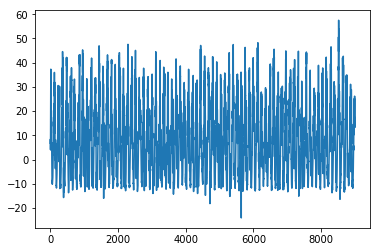

In [16]:
plt.plot(data)

### Wrap it up in a function

In [20]:
import os

In [27]:
def get_model_data(url=URL, fname='data.dat',
                   force_download=False):
    """
    Function to download Manoj's data
    """
    if not os.path.exists(fname) or force_download:
        urlretrieve(URL, fname)
        print('Downloading...')
    data = np.genfromtxt(fname)
    
    return data.flatten()

In [29]:
data = get_model_data(force_download=False)

-----------_

### ASIDE: What if you want to use labelled arrays?

In [34]:
import cf_units

In [35]:
import iris

In [36]:
t_unit = cf_units.Unit('days since 0001-01-01 00:00:00',
                       calendar='360_day')

In [39]:
t_coord = iris.coords.DimCoord(np.arange(0, 360 * 75, 3),
                               units=t_unit,
                               standard_name='time')

In [44]:
cube = iris.cube.Cube(data=data,
                      units='m/s',
                      dim_coords_and_dims=[(t_coord, 0)])
cube.rename('eastward_wind')

In [46]:
import iris.coord_categorisation

In [47]:
iris.coord_categorisation.add_season(cube, 'time',
                                     name='clim_season')
iris.coord_categorisation.add_season_year(cube, 'time',
                                          name='season_year')

In [48]:
print(cube)

eastward_wind / (m/s)               (time: 9000)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          clim_season                    x
          season_year                    x


In [51]:
cube.coord('clim_season')

AuxCoord(array(['djf', 'djf', 'djf', ..., 'djf', 'djf', 'djf'], 
      dtype='<U64'), standard_name=None, units=Unit('no_unit'), long_name='clim_season')

In [49]:
for season, year in zip(cube.coord('clim_season')[:100:10].points,
                        cube.coord('season_year')[:100:10].points):
    print(season + ' ' + str(year))

djf 1
djf 1
mam 1
mam 1
mam 1
jja 1
jja 1
jja 1
son 1
son 1


In [52]:
annual_seasonal_mean = cube.aggregated_by(['clim_season', 'season_year'],
                                          iris.analysis.MEAN)

In [53]:
print(annual_seasonal_mean)

eastward_wind / (m/s)               (time: 301)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          clim_season                    x
          season_year                    x
     Cell methods:
          mean: clim_season, season_year


Source: http://scitools.org.uk/iris/docs/latest/userguide/cube_statistics.html

-----------_

In [55]:
data.shape

(9000,)

### Reshape the array to YEARS $\times$ DAYS

In [56]:
NDAYS = 120  # the number of 3-day periods in a 360-day year
NYEARS = 75  # the total number of years

In [57]:
data_yd = data.reshape((NYEARS, NDAYS))
print(data_yd.shape)

(75, 120)


In [58]:
data_yd[-1, 10]

23.914400000000001

In [62]:
data_yd[0, -10:], data_yd[1, :20]

(array([ 15.5446,  20.6539,  16.4162,  22.0274,  30.3875,  27.8614,
         28.5274,  32.0706,  35.9934,  34.0339]),
 array([  3.06054000e+01,   2.61758000e+01,   2.98059000e+01,
          3.20111000e+01,   2.72294000e+01,   1.97748000e+01,
          1.90082000e+01,   1.51616000e+01,   1.22748000e+01,
          1.09608000e+01,   1.36364000e+01,   2.22356000e+01,
          2.76375000e+01,   2.39670000e+01,   1.24344000e+01,
          2.54243000e+00,   2.32738000e-01,  -3.17650000e-02,
          6.82037000e-01,   4.43382000e-02]))

## Select only winter months

In [67]:
data_djf = np.hstack([data_yd[:-1, -10:],
                      data_yd[1:, :20]])

what does `hstack` function do?

In [68]:
data_djf.shape

(74, 30)

In [71]:
yr

array([ 25.497  ,  20.5991 ,  19.3097 ,  23.6057 ,  31.0942 ,  28.5473 ,
        18.8359 ,  21.0333 ,  13.802  ,  17.554  ,  19.8351 ,  15.8329 ,
        10.7086 ,  12.6061 ,   8.55695,  -4.9717 ,   1.02354,  11.2588 ,
        18.9865 ,  21.5986 ,  23.9144 ,  23.1307 ,  24.7501 ,  26.0248 ,
        23.134  ,  14.8906 ,  21.2463 ,  28.8961 ,  27.64   ,  25.4356 ])

In [72]:
condition = yr > 0

In [73]:
condition

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

In [74]:
np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2]

array([15, 14])

In [77]:
condition = data_djf > 0

In [78]:
condition.shape

(74, 30)

In [76]:
for i, yr in enumerate(data_djf):
    condition = yr > 0
    lens_true = np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2]
    if 20 <= lens_true[0] < 30:
        print(i, lens_true[0])

0 27
1 23
5 27
7 27
8 20
12 24
14 25
17 21
20 23
22 26
25 27
26 21
28 20
29 25
30 24
33 29
57 25
61 21
65 20
66 29


In [125]:
[*enumerate(yr)]

[(0, 25.497),
 (1, 20.5991),
 (2, 19.309699999999999),
 (3, 23.605699999999999),
 (4, 31.094200000000001),
 (5, 28.5473),
 (6, 18.835899999999999),
 (7, 21.033300000000001),
 (8, 13.802),
 (9, 17.553999999999998),
 (10, 19.835100000000001),
 (11, 15.8329),
 (12, 10.708600000000001),
 (13, 12.6061),
 (14, 8.5569500000000005),
 (15, -4.9717000000000002),
 (16, 1.0235399999999999),
 (17, 11.258800000000001),
 (18, 18.986499999999999),
 (19, 21.598600000000001),
 (20, 23.914400000000001),
 (21, 23.130700000000001),
 (22, 24.7501),
 (23, 26.024799999999999),
 (24, 23.134),
 (25, 14.890599999999999),
 (26, 21.246300000000002),
 (27, 28.896100000000001),
 (28, 27.640000000000001),
 (29, 25.435600000000001)]

In [126]:
np.diff(np.where(np.concatenate([[condition[0]],
                                  condition[:-1] != condition[1:],
                                  [True]]))[0])[::2]

array([15,  1, 14])

In [127]:
np.concatenate(([condition[0]],
                                  condition[:-1] != condition[1:],
                                  [True]))

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True], dtype=bool)

In [132]:
condition[:-1] != condition[1:]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=bool)

In [141]:
np.diff(np.where(np.concatenate([[condition[0]], condition[:-1] != condition[1:], [True]]))[0])[0]

15